In [241]:
import matplotlib.pyplot as plt
import pennylane as qml
import scipy as sp

from pennylane import numpy as np
from IPython.display import display, Math

np.set_printoptions(threshold=np.inf, linewidth=np.inf)
np.set_printoptions()

dev = qml.device('default.qubit', wires= 2)

# == Pre_defined state ==
pauli_x = np.array([ [0, 1], [1, 0]])
pauli_y = np.array([ [0, -1.j], [1.j, 0]])
pauli_z = np.array([ [1, 0], [0, -1]])

# state = (00 + 01 + 10 + 11)/2 = kron(|0> + |1>)/sqrt(2) , (|0> + |1>)/sqrt(2) )
state_super_pos = np.kron( (np.array([[1], [0]]) + np.array([[0], [1]]))/np.sqrt(2) , (np.array([[1], [0]]) + np.array([[0], [1]]))/np.sqrt(2) )
rho_super_pos = np.kron(state_super_pos, state_super_pos.conj().T) 
# state_super_pos, state_super_pos.con().T has different dimension 


# print(rho_super_pos)
# print(state_super_pos)

# bell state = (|00> + |11>) / 2
state_bell = ( np.kron( np.array([ [1], [0] ]) , np.array([ [1], [0] ]) ) +  np.kron( np.array([ [0], [1] ]) , np.array([ [0], [1] ]) ) )/np.sqrt(2) 
# rho_bell = state_bell @ state_bell.conj().T
rho_bell = np.kron(state_bell , state_bell.conj().T)

print('bell_state:\n',rho_bell)

bell_state:
 [[0.5 0.  0.  0.5]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.5 0.  0.  0.5]]


Hamiltonian:
   (1) [Z0 Z1] 



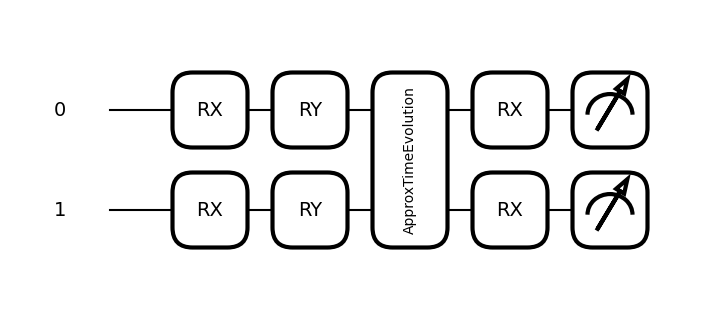

In [242]:
# == Hamiltonian setup ==
coeffs = [1]
obs = [qml.PauliZ(0) @ qml.PauliZ(1)]

hamiltonian = qml.Hamiltonian(coeffs, obs)
print('Hamiltonian:\n', hamiltonian,'\n')


# Quantum circuit
@qml.qnode(dev)
def circuit(theta_1, theta_2, tau):
    
    qml.RX(np.pi/2, wires = 0)
    qml.RX(np.pi/2, wires = 1)
    # qml.RX(theta_1, wires = 0)
    # qml.RX(theta_1, wires = 1)
    
    qml.RY(np.pi/2, wires = 0)
    qml.RY(np.pi/2, wires = 1)
    
    # qml.Hadamard(wires = 0)
    # qml.Hadamard (wires = 1)
    
    qml.ApproxTimeEvolution(hamiltonian, tau, 1)
    
    qml.RX(np.pi/2, wires = 0)
    qml.RX(np.pi/2, wires = 1)
    
    # qml.RY(np.pi/2, wires = 0)
    # qml.RY(np.pi/2, wires = 1)
    
    # qml.Hadamard( wires = 0)
    # qml.Hadamard( wires = 1)
    
    
    # qml.Hadamard(wires = 0)
    
    # qml.CNOT(wires=[0,1])

    
    return qml.density_matrix(wires=[0, 1])

fig, ax = qml.draw_mpl(circuit)(0,0,1)

# Get demsity matrix from the circuit
time_for_evo = np.pi/4
rho_from_circuit = (circuit(0,0,time_for_evo))

In [243]:
# == Double check density matrix == 

coeff_test = 1
obs_test = np.kron(pauli_z, pauli_z)

hamiltonian_test = coeff_test * obs_test
print('hamiltonian_test(Z-Z): \n',hamiltonian_test,'\n')

# select test time 
time_test = np.pi/4

def X_rot(theta):
    return np.kron(sp.linalg.expm(-1j * pauli_x * theta/2), sp.linalg.expm(-1j * pauli_x * theta/2))

def Y_rot(theta):
    return np.kron(sp.linalg.expm(-1j * pauli_y * theta/2), sp.linalg.expm(-1j * pauli_y * theta/2))

def time_evolve(tau):
    return sp.linalg.expm(-1.j * hamiltonian_test * tau)

state_test = X_rot(np.pi/2) @ time_evolve(time_test) @ X_rot(np.pi/2) @ np.array([1,0,0,0]).reshape(4,1)
# test_y_rot = Y_rot(np.pi/2) @ time_evolve(time) @ Y_rot(np.pi/2) @ np.array([1,0,0,0]).reshape(4,1)

rho_test = np.kron(state_test, state_test.conj().T)
# rho_test = np.kron(test_y_rot, test_y_rot.conj().T)

print('rho_from_circuit:\n',rho_from_circuit,'\n')
print('rho_numerical:\n',rho_test,'\n')
print('Check for the result: \n',np.isclose(rho_from_circuit, rho_test))

hamiltonian_test(Z-Z): 
 [[ 1  0  0  0]
 [ 0 -1  0  0]
 [ 0  0 -1  0]
 [ 0  0  0  1]] 

rho_from_circuit:
 [[ 5.00000000e-01+0.00000000e+00j -2.77555756e-17+4.62223187e-33j  2.31111593e-33+1.38777878e-17j -1.38777878e-17+5.00000000e-01j]
 [-2.77555756e-17-4.62223187e-33j  1.54074396e-33+0.00000000e+00j  0.00000000e+00-7.70371978e-34j  5.39260384e-33-2.77555756e-17j]
 [ 2.31111593e-33-1.38777878e-17j  0.00000000e+00+7.70371978e-34j  3.85185989e-34+0.00000000e+00j  1.38777878e-17+2.69630192e-33j]
 [-1.38777878e-17-5.00000000e-01j  5.39260384e-33+2.77555756e-17j  1.38777878e-17-2.69630192e-33j  5.00000000e-01+0.00000000e+00j]] 

rho_numerical:
 [[5.00000000e-01+0.00000000e+00j 8.66340428e-17+8.12941988e-18j 8.66340428e-17+8.12941988e-18j 1.62588398e-17+5.00000000e-01j]
 [8.66340428e-17-8.12941988e-18j 1.51430897e-32+0.00000000e+00j 1.51430897e-32+0.00000000e+00j 8.12941988e-18+8.66340428e-17j]
 [8.66340428e-17-8.12941988e-18j 1.51430897e-32+0.00000000e+00j 1.51430897e-32+0.00000000e+00j 8

/var/folders/w1/ls_y8xbd21b7x0tbqwgfdcd00000gn/T/ipykernel_1244/263587641.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(state)
/var/folders/w1/ls_y8xbd21b7x0tbqwgfdcd00000gn/T/ipykernel_1244/263587641.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(state_y)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


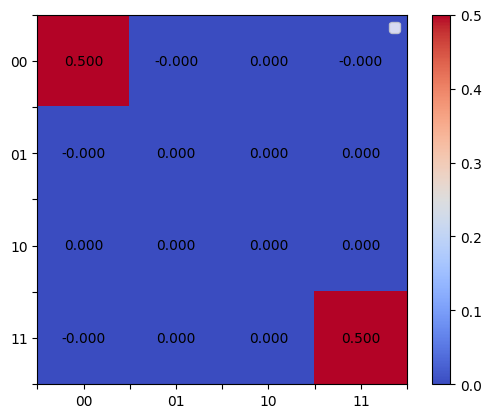

density_matrix_from_circuit:
 [[ 5.00000000e-01+0.00000000e+00j -2.77555756e-17+4.62223187e-33j  2.31111593e-33+1.38777878e-17j -1.38777878e-17+5.00000000e-01j]
 [-2.77555756e-17-4.62223187e-33j  1.54074396e-33+0.00000000e+00j  0.00000000e+00-7.70371978e-34j  5.39260384e-33-2.77555756e-17j]
 [ 2.31111593e-33-1.38777878e-17j  0.00000000e+00+7.70371978e-34j  3.85185989e-34+0.00000000e+00j  1.38777878e-17+2.69630192e-33j]
 [-1.38777878e-17-5.00000000e-01j  5.39260384e-33+2.77555756e-17j  1.38777878e-17-2.69630192e-33j  5.00000000e-01+0.00000000e+00j]]


In [244]:
# == Plot density matrix ==
# circuit density matrix

selected_density_matrix = rho_from_circuit.real

state = ["",'00',"",'01',"",'10',"",'11']
state_y = ["",'00',"",'01',"",'10',"",'11']
# state_y = ["",'11',"",'10',"",'01',"",'00']

fig, ax = plt.subplots(1,1)
plt.imshow(selected_density_matrix, cmap="coolwarm")
plt.colorbar()
ax.set_xticklabels(state)
ax.set_yticklabels(state_y)


for (j,i),label in np.ndenumerate(selected_density_matrix):
    ax.text(i,j, "{:.3f}".format(label),ha="center", va="center")
ax.legend()
plt.show()


print('density_matrix_from_circuit:\n',rho_from_circuit)

In [245]:
# # double check density matrix

# selected_density_matrix = rho_test.real

# state = ["",'00',"",'01',"",'10',"",'11']
# state_y = ["",'00',"",'01',"",'10',"",'11']
# # state_y = ["",'11',"",'10',"",'01',"",'00']

# fig, ax = plt.subplots(1,1)
# plt.imshow(selected_density_matrix, cmap="coolwarm")
# plt.colorbar()
# ax.set_xticklabels(state)
# ax.set_yticklabels(state_y)


# for (j,i),label in np.ndenumerate(selected_density_matrix):
#     ax.text(i,j, "{:.3f}".format(label),ha="center", va="center")
# ax.legend()
# plt.show()


# print('density_matrix_from_double check:\n',rho_test)

/var/folders/w1/ls_y8xbd21b7x0tbqwgfdcd00000gn/T/ipykernel_1244/692226230.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(state)
/var/folders/w1/ls_y8xbd21b7x0tbqwgfdcd00000gn/T/ipykernel_1244/692226230.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(state_y)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


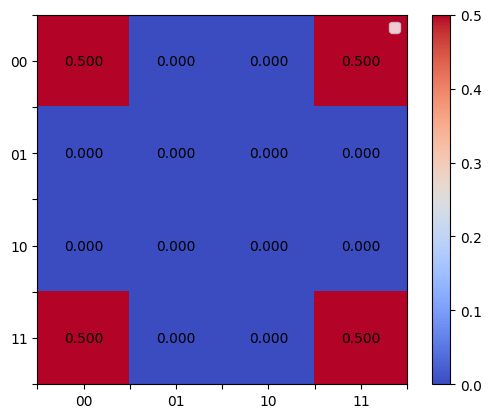

In [246]:
# == Bell state_ for comparsion ==

selected_density_matrix = rho_bell.real

state = ["",'00',"",'01',"",'10',"",'11']
state_y = ["",'00',"",'01',"",'10',"",'11']
# state_y = ["",'11',"",'10',"",'01',"",'00']

fig, ax = plt.subplots()
plt.imshow(selected_density_matrix, cmap="coolwarm")
plt.colorbar()
ax.set_xticklabels(state)
ax.set_yticklabels(state_y)


for (j,i),label in np.ndenumerate(selected_density_matrix):
    ax.text(i,j, "{:.3f}".format(label),ha="center", va="center")
ax.legend()
plt.show()

In [247]:
# == Optimization begin ==

def calculate_fidelity(tau):
    fidelity = qml.math.fidelity(rho_bell, circuit(0,0,tau))
    
    return 1-fidelity


Init_parameters = np.pi/4
result = sp.optimize.minimize(calculate_fidelity, Init_parameters, method='SLSQP')

print(result,'\n')

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.5000000000000004
       x: [ 7.854e-01]
     nit: 1
     jac: [ 0.000e+00]
    nfev: 2
    njev: 1 



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pennylane/math/quantum.py:46: UserWarning: Argument passed to fidelity has shape (4, 4) and will be interpreted as a density matrix. If a batched state vector was intended, please call qml.math.dm_from_state_vector first, as passing state vectors to fidelity is deprecated.
  warnings.warn(


/var/folders/w1/ls_y8xbd21b7x0tbqwgfdcd00000gn/T/ipykernel_1244/208550072.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(state)
/var/folders/w1/ls_y8xbd21b7x0tbqwgfdcd00000gn/T/ipykernel_1244/208550072.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(state_y)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


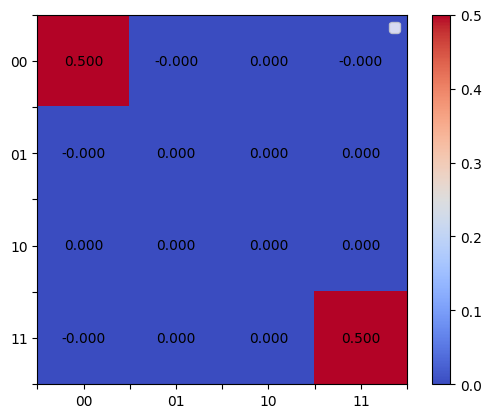

In [248]:
# == After optimize ==

selected_density_matrix = circuit(0,0,result.x[0]).real

state = ["",'00',"",'01',"",'10',"",'11']
state_y = ["",'00',"",'01',"",'10',"",'11']
# state_y = ["",'11',"",'10',"",'01',"",'00']

fig, ax = plt.subplots(1,1)
plt.imshow(selected_density_matrix, cmap="coolwarm")
plt.colorbar()
ax.set_xticklabels(state)
ax.set_yticklabels(state_y)


for (j,i),label in np.ndenumerate(selected_density_matrix):
    ax.text(i,j, "{:.3f}".format(label),ha="center", va="center")
ax.legend()
plt.show()